# Monte Carlo class usage

![Landing point dispersion ellipses](https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/monte_carlo_analysis/monte_carlo_analysis_outputs/valetudo_rocket_v0.svg)

This is an advanced use of RocketPy. This notebook runs a Monte Carlo analysis and predicts probability distributions of the rocket's landing point, apogee and other relevant information. 

The `MonteCarlo` class simplifies the process of performing Monte Carlo simulations. The idea is to take the already defined classes for a standard flight simulation, and create the so called ``Stochastic`` classes, which are used to run the Monte Carlo analysis.

This class offers extensive capabilities, and this example notebook covers as many as possible.
For a deeper understanding, we recommend checking the class [documentation](https://docs.rocketpy.org/en/latest/).

For a more comprehensive conceptual understanding of Monte Carlo Simulations, refer to RocketPy's main reference: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331).



In [55]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's import the necessary libraries

In [56]:
import datetime

from rocketpy import Environment, Flight, Function, MonteCarlo, Rocket, SolidMotor
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticNoseCone,
    StochasticParachute,
    StochasticRailButtons,
    StochasticRocket,
    StochasticSolidMotor,
    StochasticTail,
    StochasticTrapezoidalFins,
)

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [57]:
#%matplotlib widget

## Step 1: Standard Simulation


We will first create a standard RocketPy simulation objects (e.g. Environment, SolidMotor, etc.) to then create the Stochastic objects.

The standard objects created here are the same as in the [First Simulation Page](https://docs.rocketpy.org/en/latest/user/first_simulation.html) of our documentation, so you can go through that if you want to understand what is done in more detail.

The only difference here is that we will use a `Environment` with atmospheric model type `Ensemble`. This allows us to run the Monte Carlo analysis with different ensemble members, which are different atmospheric profiles.

We will do it all in one single cell for simplicity.

In [58]:
# Environment
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type="Ensemble", file="GEFS")

# Motor
motor = SolidMotor(
    thrust_source="../../../data/motors/cesaroni/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

# Rocket
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/rockets/defiance/DragCurve.csv",
    power_on_drag="../../../data/rockets/defiance/DragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/airfoils/NACA0012-radians.txt", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Flight
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

oc_open: server error retrieving url: code=0 message="/gens_bc/gens20250429/gep_all_12z is not an available dataset"

Total Impulse of the Solid Motor: 6026.35 Ns


Lets check the trajectory of the Flight.

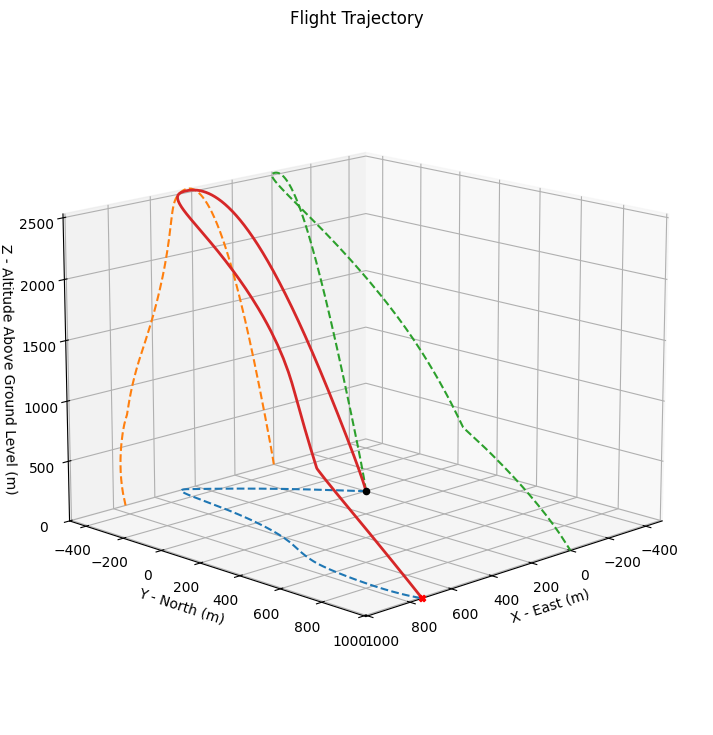

In [59]:
test_flight.plots.trajectory_3d()

The flight trajectory above represents the nominal trajectory of the rocket, without any uncertainties.


## Step 2: Stochastic Objects

For each RocketPy object, we will create a ``Stochastic`` counterpart that extends the initial model, allowing us to define the uncertainties of each input parameter.

Please refer to the [Working with Stochastic Objects](https://docs.rocketpy.org/en/latest/user/stochastic.html#working-with-stochastic-objects) page on RocketPy`s documentation for a more detailed explanation.

### Stochastic Environment


Starting with the `Environment` object, we will create a `StochasticEnvironment` to specify its uncertainties.

In this first example, we will specify the ensemble member and wind velocities factor.

Since the ensemble member is a discrete value, **only list type inputs are permitted**. The list will contain the ensemble numbers to be randomly selected during the Monte Carlo simulation. This means that in each iteration, a different ensemble member will be chosen.

<!-- The wind velocities factor are also special inputs. They are used to scale the wind velocities in each axis. The factor inputs can only be tuples or lists, since it has no nominal value to get from the standard. Lets scale the wind by a factor of 1.00000 ± 0.2 -->

In [60]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                113
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.3897
	longitude                -8.288964
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


#### NOTE

Always check the `.visualize_attributes()` method of each stochastic object to verify the uncertainties were correctly set.


Just to illustrate the potential of this technique, let's randomly generate 5 instances of the environment using the `create_object` method.

For each instance, we will calculate the wind speed at 1km altitude and store the results in a list.

In [61]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[np.float64(-2.0452344618712908), np.float64(-1.3024509812778835), np.float64(-1.3024509812778835), np.float64(0.8084053593349103), np.float64(-4.306574719034744)]


As you can see, the wind speed varies between ensemble members.
This demonstrates how the Monte Carlo simulation can capture the variability in wind conditions due to different ensemble members.


### Motor


We can now create a `StochasticSolidMotor` object to define the uncertainties associated with the motor.
In this example, we will apply more complex uncertainties to the motor parameters.

The `StochasticSolidMotor` also has one special parameter which is the `total_impulse`. It lets us alter the total impulse of the motor while maintaining the thrust curve shape. This is particularly useful for motor uncertainties.

In [62]:
stochastic_motor = StochasticSolidMotor(
    solid_motor=motor,
    burn_start_time=(0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    3.9
	center_of_dry_mass_position      0.317
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.125
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.125
	dry_I_23                         0
	dry_I_33                         0.002
	dry_mass                         1.815
	grain_number                     5
	interpolate                      linear
	thrust_source                    [[0, 0], [0.055, 100.0], [0.092, 1500.0], [0.1, 2000.0], [0.15, 2200.0], [0.2, 1800.0], [0.5, 1950.0], [1.0, 2034.0], [1.5, 2000.0], [2.0, 1900.0], [2.5, 1760.0], [2.9, 1700.0], [3.0, 1650.0], [3.3, 530.0], [3.4, 350.0], [3.9, 0.0]]

Stochastic Attributes:
	burn_start_time                  0.00000 ± 0.10000 (binomial)
	grain_density                    1815.00000 ± 50.00000 (normal)
	grain_ini

#### NOTE

Pay special attention to how different input types are interpreted in the `StochasticSolidMotor` object by checking the printed object:


<!-- - ``thrust_source`` was given as a list of 3 items, and is saved as is. This means that the simulation will randomly chose one item of that list, as desired -->

- ``burn_start_time`` was given as a tuple of 3 items, specifying the nominal value, the standard deviation and the distribution type

- ``total_impulse`` was given as a tuple of 2 numbers, so the distribution type was set to the default: `normal`

- All other values set for the other parameters in the constructor are simple values, which means they are interpreted as standard deviation and the nominal value is taken from the ``motor``

- The remaining parameters that are printed are just the nominal values from the ``motor``. In the ``Stochastic`` object they are saved as a list of one item



Once again, we can illustrate the power of stochastic modeling by generating multiple instances of the `SolidMotor` class using the `StochasticSolidMotor` object.
For each instance, we will calculate the total impulse and store the results in a list. This will show how the uncertainties in the motor parameters affect the total impulse over multiple iterations.


In [63]:
total_impulse = []
for i in range(5):
    rnd_motor = stochastic_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[np.float64(6136.638479513408), np.float64(6799.007538770442), np.float64(4937.429919089983), np.float64(7436.3624422183975), np.float64(6720.410109573637)]


### Rocket


We can now create a `StochasticRocket` object to define the uncertainties associated with the rocket.

In [64]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)


The `StochasticRocket` still needs to have its aerodynamic surfaces and parachutes added. 

We can also create stochastic models for each aerodynamic surface, although this is not mandatory.

In [65]:
stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

Then we must add them to our stochastic rocket, much like we do in the normal Rocket.



In [66]:
stochastic_rocket.add_motor(stochastic_motor, position=0.001)
stochastic_rocket.add_nose(stochastic_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.set_rail_buttons(
    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

#### NOTE

The `position` arguments behave just like the other ``Stochastic`` classes parameters



Now lets check how the `StochasticRocket` handled all these additions

In [67]:
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)



### Flight


After defining the `Flight`, we can create the corresponding `Stochastic` object to define the uncertainties of the input parameters.

In [68]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5

Stochastic Attributes:
	heading               53.00000 ± 2.00000 (normal)
	inclination           84.70000 ± 1.00000 (normal)


### Step 2: Starting the Monte Carlo Simulations


First, let's invoke the `MonteCarlo` class, we are going to need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [69]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt
A total of 10 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt


Finally, let's simulate our flights. 
We can run the simulations using the method `MonteCarlo.simulate()`.

Set `append=False` to overwrite the previous results, or `append=True` to add the new results to the previous ones.


In [70]:
test_dispersion.simulate(
    number_of_simulations=10,
    append=False,
    #include_function_data=False,
    #parallel=True,
    #n_workers=4,
)

Completed 10 iterations. Total CPU time: 7.7 s. Total wall time: 7.7 smated time left: 0 s
Saving results.    
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [71]:
# You only need to import results if you did not run the simulations
# test_dispersion.import_results()

In [72]:
test_dispersion.num_of_loaded_sims

10

In [73]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  10
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
                 apogee_y         181.376          88.439
     lateral_surface_wind           2.801           0.844
out_of_rail_stability_margin           2.677           0.051
              apogee_time          22.548           1.491
                 x_impact         330.976         193.393
                 y_impact        1625.405         359.091
     out_of_rail_velocity          25.869           2.021
                   apogee        2807.828         474.644
                  t_final         273.739          25.630
         out_of_rail_time           0.358           0.022
          max_mach_number           0.836           0.121
 initial_stability_margin           2.604           0.051
          impact_velocity          -5.27

Secondly, we can plot the results of the simulations.


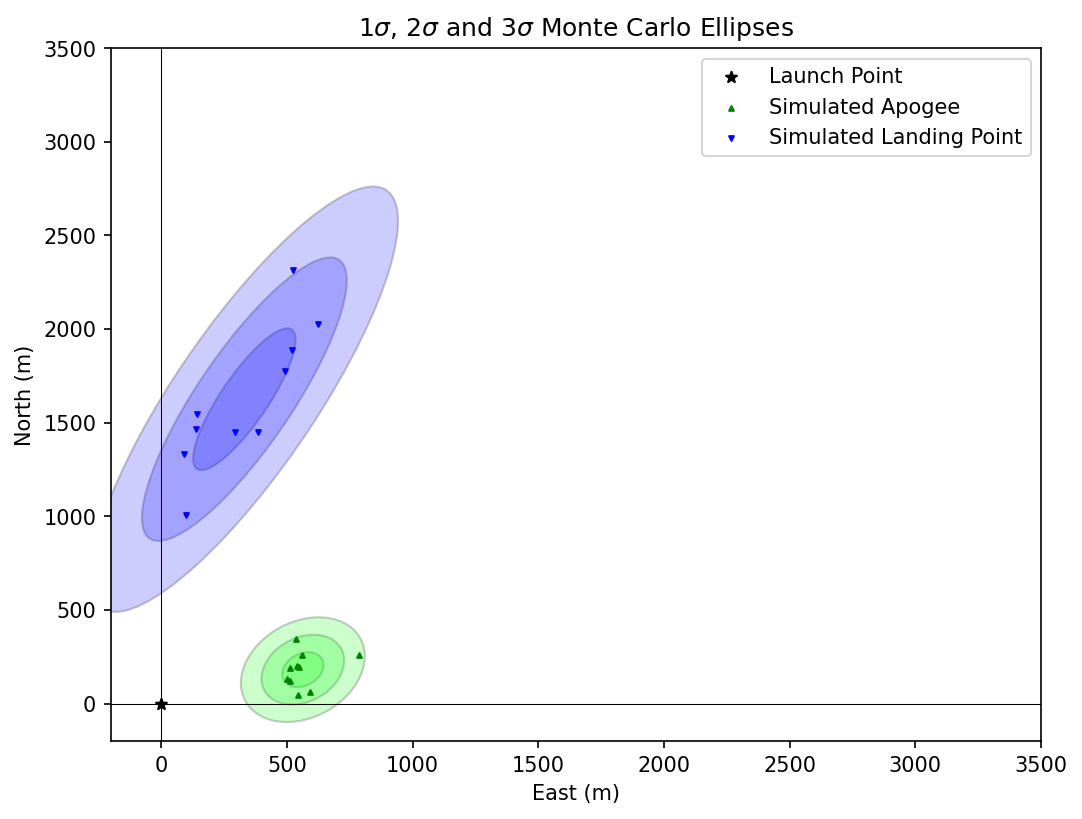

In [74]:
test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))

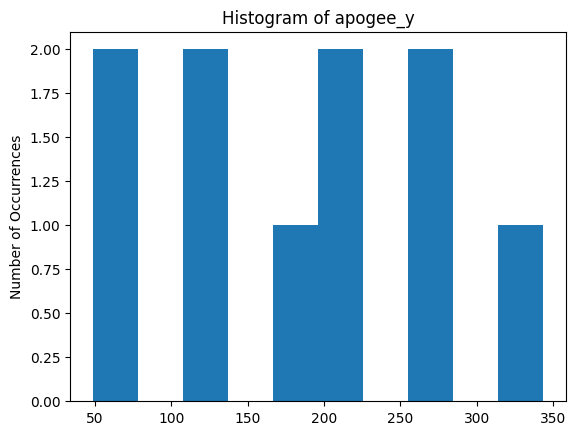

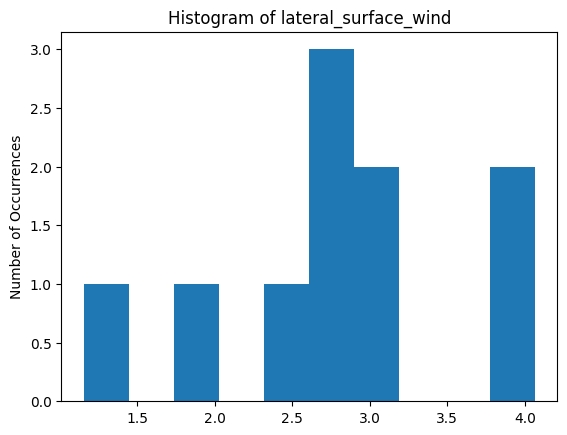

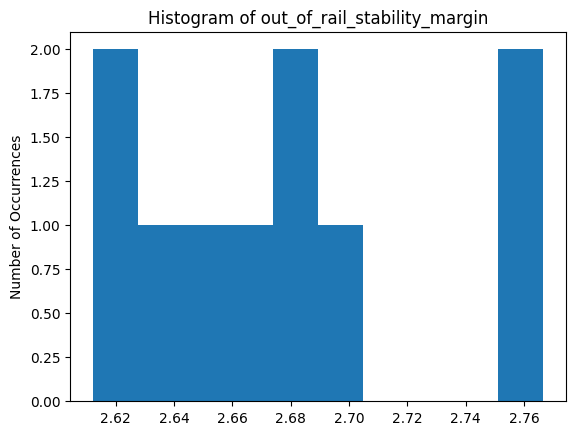

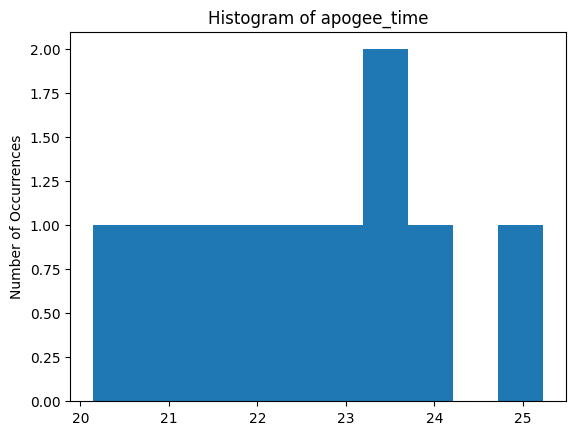

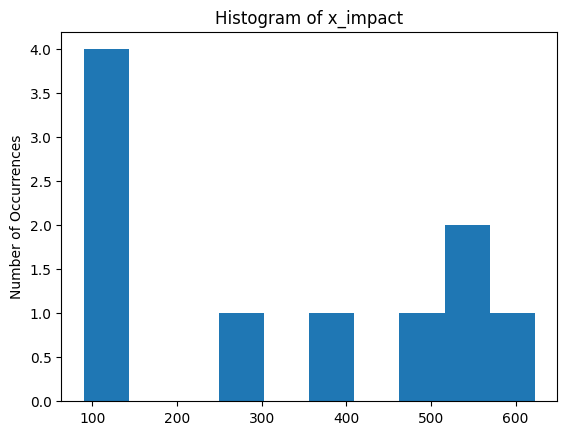

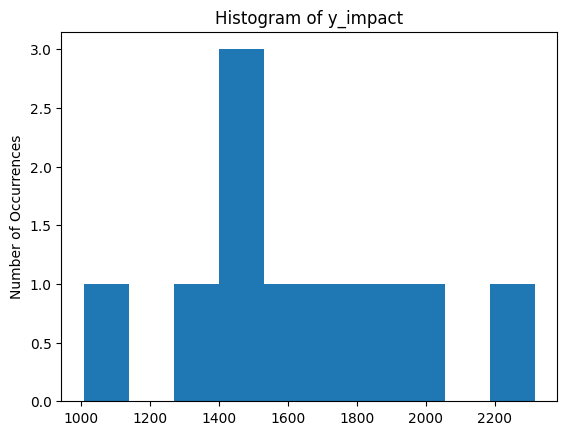

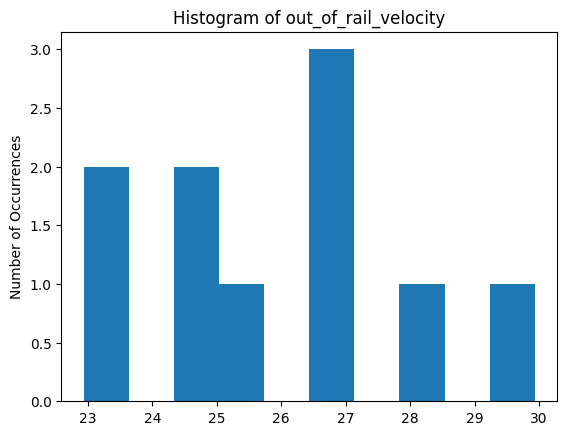

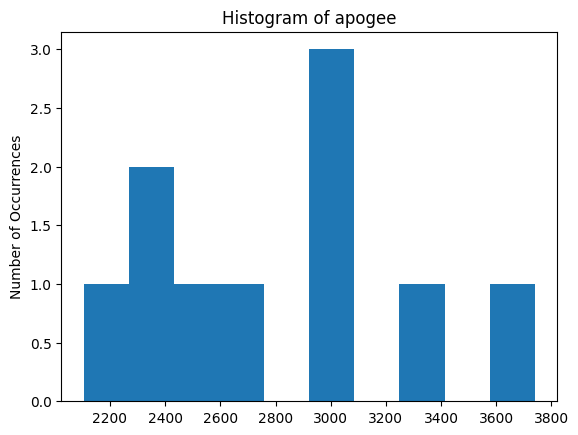

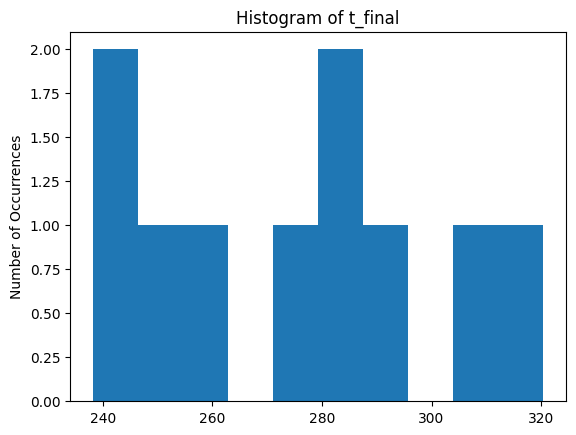

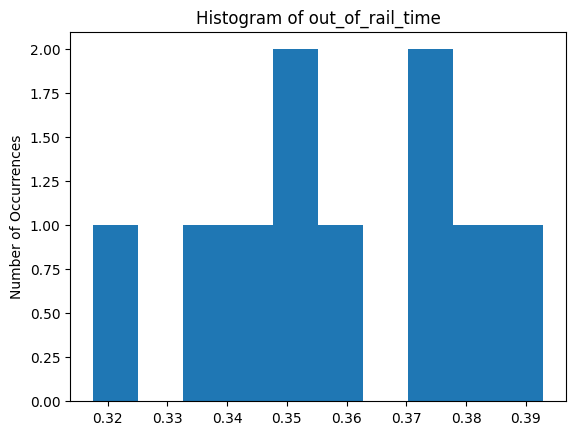

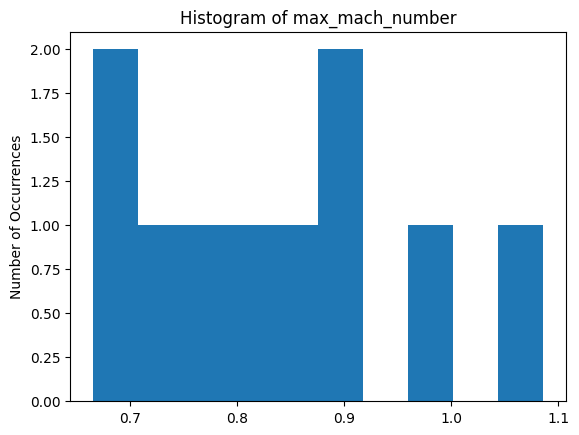

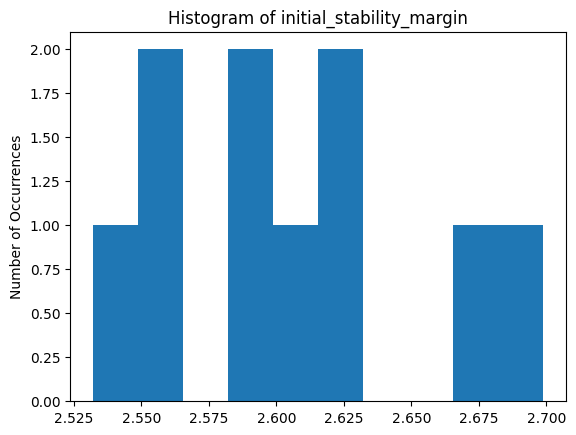

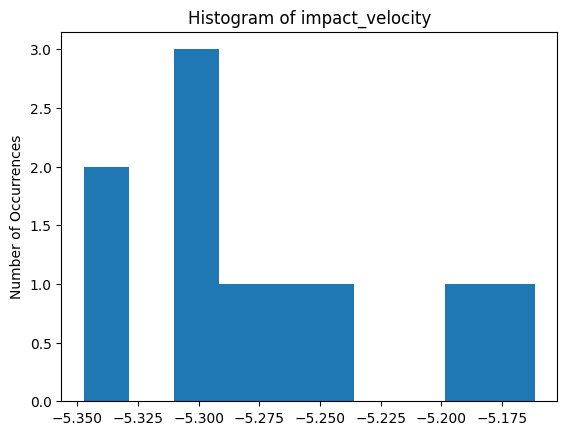

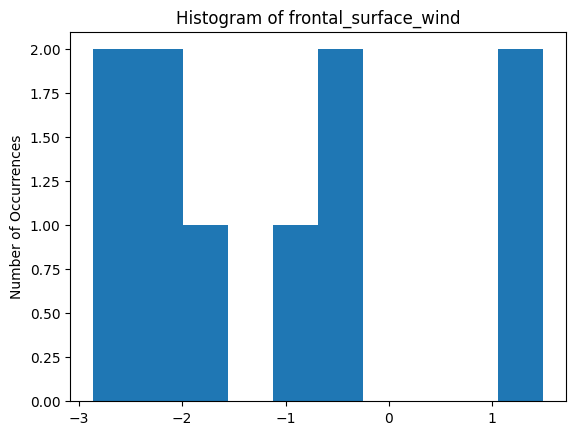

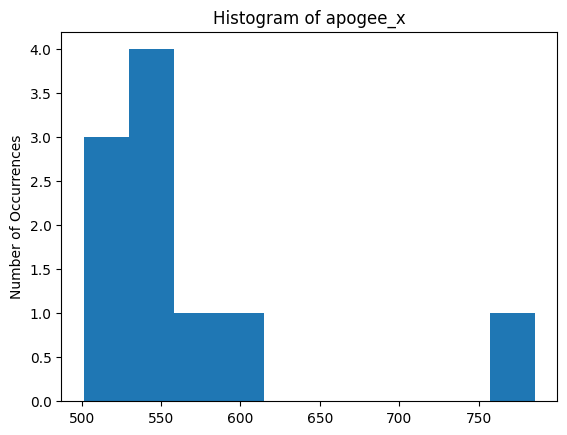

In [75]:
test_dispersion.plots.all()

Finally, one may also export the ellipses to a ``.kml`` file so it can be easily visualized in Google Earth


In [76]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)

## Custom exports using callback functions

We have shown, so far, how to perform to use the `MonteCarlo` class and visualize its results. By default, some variables exported to the output files, such as *apogee* and *x_impact*. The `export_list` argument provides a simplified way for the user to export additional variables listed in the documentation, such as *inclination* and *heading*.  

There are applications in which you might need to extract more information in the results than the `export_list` argument can handle. To that end, the `MonteCarlo` class has a `data_collector` argument which allows you customize further the output of the simulation.

To exemplify its use, we show how to export the *date* of the environment used in the simulation together with the *average reynolds number* along with the default variables.

We will use the `stochastic_env`, `stochastic_rocket` and `stochastic_flight` objects previously defined, and only change the `MonteCarlo` object. First, we need to define our customized data collector.

In [77]:
import numpy as np


# Defining custom callback functions
def get_average_reynolds_number(flight):
    reynold_number_list = flight.reynolds_number(flight.time)
    average_reynolds_number = np.mean(reynold_number_list)
    return average_reynolds_number


def get_date(flight):
    return flight.env.date


custom_data_collector = {
    "average_reynolds_number": get_average_reynolds_number,
    "date": get_date,
}

The `data_collector` must be a dictionary whose keys are the names of the variables we want to export and the values are callback functions (python callables) that compute these variable values. Notice how we can compute complex expressions in this function and just export the result. For instance, the *get_average_reynolds_number* calls the `flight.reynolds_number` method for each value in `flight.time` list and computes the average value using numpy's `mean`. The *date* variable is straightforward.

After we define the data collector, we pass it as an argument to the `MonteCarlo` class.

In [78]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example_customized",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
    export_list=["apogee", "apogee_time", "x_impact"],
    data_collector=custom_data_collector,
)

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example_customized.inputs.txt
A total of 10 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example_customized.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example_customized.errors.txt


In [79]:
test_dispersion.simulate(number_of_simulations=10, append=False)

Completed 10 iterations. Total CPU time: 7.3 s. Total wall time: 7.1 smated time left: 0 s
Saving results.    
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example_customized.outputs.txt


In [80]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example_customized
Number of simulations:  10
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
                   apogee        2730.310         567.184
              apogee_time          22.241           2.002
                 x_impact         334.845         195.136
  average_reynolds_number     1027852.887      167639.625
                     date         517.750         870.262
